# Compare JJA temperature

Author: Ziqi Yin

Last modified: 2025 Feb 21

Table of contents:
* [Maps of summer NH lower troposphere summer virtual temperature differences, and near-surface temperature differences](#first-bullet)

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from statistics import mode
import pandas as pd
from scipy import signal
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
from matplotlib.collections import PolyCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import geocat.comp as gc #to interpolate and extrapolate data from hybrid-sigma levels to isobaric levels

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')
from functions import *

import warnings
warnings.filterwarnings('ignore')

# For regridding
import os
import ESMF
#import xesmf as xe

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


In [2]:
## Parameter
g = 9.80616 #[m/s2]
Rd = 287.0423 #[J/kg/K]
p0 = 1e5 #[Pa]

### Read data

In [3]:
## BG iteration 7
BG7_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_Z3_JJA_yearly.nc')['Z3'] #geopotential height(asl) [m]
BG7_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PS_JJA_yearly.nc')['PS'] #surface pressure [Pa]
BG7_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_T_JJA_yearly.nc')['T'].isel(lev=-1) #bottom layer temperature [K]
BG7_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PHIS_JJA_yearly.nc')['PHIS'] #surface geopotential [m2/s2]
hyam = xr.open_dataset('/glade/campaign/cesm/development/liwg/CESM21-CISM2-JG-BG-Dec2018/archive/BG_iteration_7/atm/hist/BG_iteration_7.cam.h0.0001-12.nc')['hyam'] #hybrid A coefficient at layer midpoints [] 
hybm = xr.open_dataset('/glade/campaign/cesm/development/liwg/CESM21-CISM2-JG-BG-Dec2018/archive/BG_iteration_7/atm/hist/BG_iteration_7.cam.h0.0001-12.nc')['hybm'] #hybrid B coefficient at layer midpoints []
f09_lon = BG7_Z3_JJA_yearly.lon
f09_lat = BG7_Z3_JJA_yearly.lat

BG7_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_TREFHT_JJA_yearly.nc')['TREFHT'] #TREFHT (2m air temperature)[K]

In [4]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_Z3_1pctCO2_JJA_yearly.nc')['Z3'][:140,:,:,:]
f09_1pctCO2_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PS_1pctCO2_JJA_yearly.nc')['PS'][:140,:,:]
f09_1pctCO2_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_T_1pctCO2_JJA_yearly.nc')['T'][:140,:,:,:].isel(lev=-1)
f09_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PHIS_1pctCO2_JJA_yearly.nc')['PHIS'][:140,:,:]

f09_1pctCO2_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT'][:140,:,:]

# 4xext
f09_4xext_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_Z3_4xext_JJA_yearly.nc')['Z3']
f09_4xext_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PS_4xext_JJA_yearly.nc')['PS']
f09_4xext_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_T_4xext_JJA_yearly.nc')['T'].isel(lev=-1)
f09_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PHIS_4xext_JJA_yearly.nc')['PHIS']

f09_4xext_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_TREFHT_4xext_JJA_yearly.nc')['TREFHT']

In [5]:
## f09nohacks
# piControl
f09_nohacks_piControl_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_Z3_piControl_JJA_yearly.nc')['Z3']
f09_nohacks_piControl_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PS_piControl_JJA_yearly.nc')['PS']
f09_nohacks_piControl_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_T_piControl_JJA_yearly.nc')['T'].isel(lev=-1)
f09_nohacks_piControl_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_piControl_JJA_yearly.nc')['PHIS']

f09_nohacks_piControl_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_piControl_JJA_yearly.nc')['TREFHT']

# 1pctCO2
f09_nohacks_1pctCO2_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_Z3_1pctCO2_JJA_yearly.nc')['Z3']
f09_nohacks_1pctCO2_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PS_1pctCO2_JJA_yearly.nc')['PS']
f09_nohacks_1pctCO2_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_T_1pctCO2_JJA_yearly.nc')['T'].isel(lev=-1)
f09_nohacks_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']

f09_nohacks_1pctCO2_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT']

# 4xext
f09_nohacks_4xext_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_Z3_4xext_JJA_yearly.nc')['Z3']
f09_nohacks_4xext_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PS_4xext_JJA_yearly.nc')['PS']
f09_nohacks_4xext_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_T_4xext_JJA_yearly.nc')['T'].isel(lev=-1)
f09_nohacks_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_4xext_JJA_yearly.nc')['PHIS']

f09_nohacks_4xext_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_TREFHT_4xext_JJA_yearly.nc')['TREFHT']

In [6]:
## Arctic grid
# piControl
ARCTIC_piControl_p4_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_Z3_piControl_p4_JJA_yearly.nc')['Z3']
ARCTIC_piControl_p4_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PS_piControl_p4_JJA_yearly.nc')['PS']
ARCTIC_piControl_p4_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_T_piControl_p4_JJA_yearly.nc')['T'].isel(lev=-1)
ARCTIC_piControl_p4_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_piControl_p4_JJA_yearly.nc')['PHIS']
ARCTIC_ncol = ARCTIC_piControl_p4_Z3_JJA_yearly.ncol

ARCTIC_piControl_p4_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_piControl_p4_JJA_yearly.nc')['TREFHT']

# 1pctCO2
ARCTIC_1pctCO2_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_Z3_1pctCO2_JJA_yearly.nc')['Z3']
ARCTIC_1pctCO2_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PS_1pctCO2_JJA_yearly.nc')['PS']
ARCTIC_1pctCO2_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_T_1pctCO2_JJA_yearly.nc')['T'].isel(lev=-1)
ARCTIC_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']

ARCTIC_1pctCO2_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_1pctCO2_JJA_yearly.nc')['TREFHT']

# 4xext
ARCTIC_4xext_Z3_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_Z3_4xext_JJA_yearly.nc')['Z3']
ARCTIC_4xext_PS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PS_4xext_JJA_yearly.nc')['PS']
ARCTIC_4xext_Tbot_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_T_4xext_JJA_yearly.nc')['T'].isel(lev=-1)
ARCTIC_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_4xext_JJA_yearly.nc')['PHIS']

ARCTIC_4xext_TREFHT_JJA_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_TREFHT_4xext_JJA_yearly.nc')['TREFHT']

### Calculate

In [7]:
# Concat 1pctCO2 and 4xext periods
f09_1pctCO2_4xext_Z3_JJA_yearly = xr.concat([f09_1pctCO2_Z3_JJA_yearly, f09_4xext_Z3_JJA_yearly], dim='time')
f09_1pctCO2_4xext_PS_JJA_yearly = xr.concat([f09_1pctCO2_PS_JJA_yearly, f09_4xext_PS_JJA_yearly], dim='time')
f09_1pctCO2_4xext_Tbot_JJA_yearly = xr.concat([f09_1pctCO2_Tbot_JJA_yearly, f09_4xext_Tbot_JJA_yearly], dim='time')
f09_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([f09_1pctCO2_PHIS_JJA_yearly, f09_4xext_PHIS_JJA_yearly], dim='time')

f09_1pctCO2_4xext_TREFHT_JJA_yearly = xr.concat([f09_1pctCO2_TREFHT_JJA_yearly, f09_4xext_TREFHT_JJA_yearly], dim='time')

f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_Z3_JJA_yearly, f09_nohacks_4xext_Z3_JJA_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_PS_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_PS_JJA_yearly, f09_nohacks_4xext_PS_JJA_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_Tbot_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_Tbot_JJA_yearly, f09_nohacks_4xext_Tbot_JJA_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_PHIS_JJA_yearly, f09_nohacks_4xext_PHIS_JJA_yearly], dim='time')

f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_TREFHT_JJA_yearly, f09_nohacks_4xext_TREFHT_JJA_yearly], dim='time')

ARCTIC_1pctCO2_4xext_Z3_JJA_yearly = xr.concat([ARCTIC_1pctCO2_Z3_JJA_yearly, ARCTIC_4xext_Z3_JJA_yearly], dim='time')
ARCTIC_1pctCO2_4xext_PS_JJA_yearly = xr.concat([ARCTIC_1pctCO2_PS_JJA_yearly, ARCTIC_4xext_PS_JJA_yearly], dim='time')
ARCTIC_1pctCO2_4xext_Tbot_JJA_yearly = xr.concat([ARCTIC_1pctCO2_Tbot_JJA_yearly, ARCTIC_4xext_Tbot_JJA_yearly], dim='time')
ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([ARCTIC_1pctCO2_PHIS_JJA_yearly, ARCTIC_4xext_PHIS_JJA_yearly], dim='time')

ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly = xr.concat([ARCTIC_1pctCO2_TREFHT_JJA_yearly, ARCTIC_4xext_TREFHT_JJA_yearly], dim='time')

In [8]:
## Select
# end of PI (year -19-0)
f09_Z3_JJA_PI = BG7_Z3_JJA_yearly[129:149,:,:,:].mean(dim='time')
f09_PS_JJA_PI = BG7_PS_JJA_yearly[129:149,:,:].mean(dim='time')
f09_Tbot_JJA_PI = BG7_Tbot_JJA_yearly[129:149,:,:].mean(dim='time')
f09_PHIS_JJA_PI = BG7_PHIS_JJA_yearly[129:149,:,:].mean(dim='time')

f09_nohacks_Z3_JJA_PI = f09_nohacks_piControl_Z3_JJA_yearly[-20:,:,:,:].mean(dim='time')
f09_nohacks_PS_JJA_PI = f09_nohacks_piControl_PS_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_Tbot_JJA_PI = f09_nohacks_piControl_Tbot_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_PHIS_JJA_PI = f09_nohacks_piControl_PHIS_JJA_yearly[-20:,:,:].mean(dim='time')

ARCTIC_Z3_JJA_PI = ARCTIC_piControl_p4_Z3_JJA_yearly[-20:,:,:].mean(dim='time')
ARCTIC_PS_JJA_PI = ARCTIC_piControl_p4_PS_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_Tbot_JJA_PI = ARCTIC_piControl_p4_Tbot_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_PHIS_JJA_PI = ARCTIC_piControl_p4_PHIS_JJA_yearly[-20:,:].mean(dim='time')

# CO2 stabilization (year 131-150)
f09_Z3_JJA_stab = f09_1pctCO2_4xext_Z3_JJA_yearly[130:150,:,:,:].mean(dim='time')
f09_PS_JJA_stab = f09_1pctCO2_4xext_PS_JJA_yearly[130:150,:,:].mean(dim='time')
f09_Tbot_JJA_stab = f09_1pctCO2_4xext_Tbot_JJA_yearly[130:150,:,:].mean(dim='time')
f09_PHIS_JJA_stab = f09_1pctCO2_4xext_PHIS_JJA_yearly[130:150,:,:].mean(dim='time')

f09_nohacks_Z3_JJA_stab = f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly[130:150,:,:,:].mean(dim='time')
f09_nohacks_PS_JJA_stab = f09_nohacks_1pctCO2_4xext_PS_JJA_yearly[130:150,:,:].mean(dim='time')
f09_nohacks_Tbot_JJA_stab = f09_nohacks_1pctCO2_4xext_Tbot_JJA_yearly[130:150,:,:].mean(dim='time')
f09_nohacks_PHIS_JJA_stab = f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly[130:150,:,:].mean(dim='time')

ARCTIC_Z3_JJA_stab = ARCTIC_1pctCO2_4xext_Z3_JJA_yearly[130:150,:,:].mean(dim='time')
ARCTIC_PS_JJA_stab = ARCTIC_1pctCO2_4xext_PS_JJA_yearly[130:150,:].mean(dim='time')
ARCTIC_Tbot_JJA_stab = ARCTIC_1pctCO2_4xext_Tbot_JJA_yearly[130:150,:].mean(dim='time')
ARCTIC_PHIS_JJA_stab = ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly[130:150,:].mean(dim='time')

# middle period (year 231-250)
f09_Z3_JJA_mid = f09_1pctCO2_4xext_Z3_JJA_yearly[230:250,:,:,:].mean(dim='time')
f09_PS_JJA_mid = f09_1pctCO2_4xext_PS_JJA_yearly[230:250,:,:].mean(dim='time')
f09_Tbot_JJA_mid = f09_1pctCO2_4xext_Tbot_JJA_yearly[230:250,:,:].mean(dim='time')
f09_PHIS_JJA_mid = f09_1pctCO2_4xext_PHIS_JJA_yearly[230:250,:,:].mean(dim='time')

f09_nohacks_Z3_JJA_mid = f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly[230:250,:,:,:].mean(dim='time')
f09_nohacks_PS_JJA_mid = f09_nohacks_1pctCO2_4xext_PS_JJA_yearly[230:250,:,:].mean(dim='time')
f09_nohacks_Tbot_JJA_mid = f09_nohacks_1pctCO2_4xext_Tbot_JJA_yearly[230:250,:,:].mean(dim='time')
f09_nohacks_PHIS_JJA_mid = f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly[230:250,:,:].mean(dim='time')

ARCTIC_Z3_JJA_mid = ARCTIC_1pctCO2_4xext_Z3_JJA_yearly[230:250,:,:].mean(dim='time')
ARCTIC_PS_JJA_mid = ARCTIC_1pctCO2_4xext_PS_JJA_yearly[230:250,:].mean(dim='time')
ARCTIC_Tbot_JJA_mid = ARCTIC_1pctCO2_4xext_Tbot_JJA_yearly[230:250,:].mean(dim='time')
ARCTIC_PHIS_JJA_mid = ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly[230:250,:].mean(dim='time')

# end of simulation (year 331-350)
f09_Z3_JJA_end = f09_4xext_Z3_JJA_yearly[-20:,:,:,:].mean(dim='time')
f09_PS_JJA_end = f09_4xext_PS_JJA_yearly[-20:,:,:].mean(dim='time')
f09_Tbot_JJA_end = f09_4xext_Tbot_JJA_yearly[-20:,:,:].mean(dim='time')
f09_PHIS_JJA_end = f09_4xext_PHIS_JJA_yearly[-20:,:,:].mean(dim='time')

f09_nohacks_Z3_JJA_end = f09_nohacks_4xext_Z3_JJA_yearly[-20:,:,:,:].mean(dim='time')
f09_nohacks_PS_JJA_end = f09_nohacks_4xext_PS_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_Tbot_JJA_end = f09_nohacks_4xext_Tbot_JJA_yearly[-20:,:,:].mean(dim='time')
f09_nohacks_PHIS_JJA_end = f09_nohacks_4xext_PHIS_JJA_yearly[-20:,:,:].mean(dim='time')

ARCTIC_Z3_JJA_end = ARCTIC_4xext_Z3_JJA_yearly[-20:,:,:].mean(dim='time')
ARCTIC_PS_JJA_end = ARCTIC_4xext_PS_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_Tbot_JJA_end = ARCTIC_4xext_Tbot_JJA_yearly[-20:,:].mean(dim='time')
ARCTIC_PHIS_JJA_end = ARCTIC_4xext_PHIS_JJA_yearly[-20:,:].mean(dim='time')

In [9]:
## Select (T2m)
# end of PI (year -19-0)
f09_TREFHT_JJA_PI = BG7_TREFHT_JJA_yearly[129:149,:,:].mean(dim='time')

f09_nohacks_TREFHT_JJA_PI = f09_nohacks_piControl_TREFHT_JJA_yearly[-20:,:,:].mean(dim='time')

ARCTIC_TREFHT_JJA_PI = ARCTIC_piControl_p4_TREFHT_JJA_yearly[-20:,:].mean(dim='time')

# CO2 stabilization (year 131-150)
f09_TREFHT_JJA_stab = f09_1pctCO2_4xext_TREFHT_JJA_yearly[130:150,:,:].mean(dim='time')

f09_nohacks_TREFHT_JJA_stab = f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly[130:150,:,:].mean(dim='time')

ARCTIC_TREFHT_JJA_stab = ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly[130:150,:].mean(dim='time')

# middle period (year 231-250)
f09_TREFHT_JJA_mid = f09_1pctCO2_4xext_TREFHT_JJA_yearly[230:250,:,:].mean(dim='time')

f09_nohacks_TREFHT_JJA_mid = f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly[230:250,:,:].mean(dim='time')

ARCTIC_TREFHT_JJA_mid = ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly[230:250,:].mean(dim='time')

# end of simulation (year 331-350)
f09_TREFHT_JJA_end = f09_1pctCO2_4xext_TREFHT_JJA_yearly[-20:,:,:].mean(dim='time')

f09_nohacks_TREFHT_JJA_end = f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly[-20:,:,:].mean(dim='time')

ARCTIC_TREFHT_JJA_end = ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly[-20:,:].mean(dim='time')

In [10]:
## Interpolate to 500hPa level or extrapolate to 1000hPa level
# interp_hybrid_to_pressure is the Python version of vinth2p/vinth2p_ecmwf (for extrapolation below ground) in NCL script

# 500 hPa level
pnew = np.array([500]) *100

f09_Z500_JJA_PI = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_PI, ps=f09_PS_JJA_PI, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
f09_nohacks_Z500_JJA_PI = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_PI, ps=f09_nohacks_PS_JJA_PI, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
ARCTIC_Z500_JJA_PI = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_PI, ps=ARCTIC_PS_JJA_PI, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

f09_Z500_JJA_stab = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_stab, ps=f09_PS_JJA_stab, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
f09_nohacks_Z500_JJA_stab = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_stab, ps=f09_nohacks_PS_JJA_stab, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
ARCTIC_Z500_JJA_stab = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_stab, ps=ARCTIC_PS_JJA_stab, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

f09_Z500_JJA_mid = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_mid, ps=f09_PS_JJA_mid, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
f09_nohacks_Z500_JJA_mid = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_mid, ps=f09_nohacks_PS_JJA_mid, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
ARCTIC_Z500_JJA_mid = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_mid, ps=ARCTIC_PS_JJA_mid, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

f09_Z500_JJA_end = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_end, ps=f09_PS_JJA_end, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
f09_nohacks_Z500_JJA_end = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_end, ps=f09_nohacks_PS_JJA_end, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
ARCTIC_Z500_JJA_end = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_end, ps=ARCTIC_PS_JJA_end, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

In [11]:
# 1000 hPa level
pnew = np.array([1000]) *100

f09_Z1000_JJA_PI = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_PI, ps=f09_PS_JJA_PI, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log', extrapolate=True, variable='geopotential', t_bot=f09_Tbot_JJA_PI, phi_sfc=f09_PHIS_JJA_PI).squeeze()
f09_nohacks_Z1000_JJA_PI = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_PI, ps=f09_nohacks_PS_JJA_PI, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log', extrapolate=True, variable='geopotential', t_bot=f09_nohacks_Tbot_JJA_PI, phi_sfc=f09_nohacks_PHIS_JJA_PI).squeeze() 
ARCTIC_Z1000_JJA_PI = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_PI, ps=ARCTIC_PS_JJA_PI, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log', extrapolate=True, variable='geopotential', t_bot=ARCTIC_Tbot_JJA_PI, phi_sfc=ARCTIC_PHIS_JJA_PI).squeeze()

f09_Z1000_JJA_stab = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_stab, ps=f09_PS_JJA_stab, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log', extrapolate=True, variable='geopotential', t_bot=f09_Tbot_JJA_stab, phi_sfc=f09_PHIS_JJA_stab).squeeze()
f09_nohacks_Z1000_JJA_stab = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_stab, ps=f09_nohacks_PS_JJA_stab, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log', extrapolate=True, variable='geopotential', t_bot=f09_nohacks_Tbot_JJA_stab, phi_sfc=f09_nohacks_PHIS_JJA_stab).squeeze() 
ARCTIC_Z1000_JJA_stab = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_stab, ps=ARCTIC_PS_JJA_stab, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log', extrapolate=True, variable='geopotential', t_bot=ARCTIC_Tbot_JJA_stab, phi_sfc=ARCTIC_PHIS_JJA_stab).squeeze()

f09_Z1000_JJA_mid = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_mid, ps=f09_PS_JJA_mid, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log', extrapolate=True, variable='geopotential', t_bot=f09_Tbot_JJA_mid, phi_sfc=f09_PHIS_JJA_mid).squeeze()
f09_nohacks_Z1000_JJA_mid = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_mid, ps=f09_nohacks_PS_JJA_mid, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log', extrapolate=True, variable='geopotential', t_bot=f09_nohacks_Tbot_JJA_mid, phi_sfc=f09_nohacks_PHIS_JJA_mid).squeeze() 
ARCTIC_Z1000_JJA_mid = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_mid, ps=ARCTIC_PS_JJA_mid, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log', extrapolate=True, variable='geopotential', t_bot=ARCTIC_Tbot_JJA_mid, phi_sfc=ARCTIC_PHIS_JJA_mid).squeeze()

f09_Z1000_JJA_end = gc.interp_hybrid_to_pressure(data=f09_Z3_JJA_end, ps=f09_PS_JJA_end, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log', extrapolate=True, variable='geopotential', t_bot=f09_Tbot_JJA_end, phi_sfc=f09_PHIS_JJA_end).squeeze()
f09_nohacks_Z1000_JJA_end = gc.interp_hybrid_to_pressure(data=f09_nohacks_Z3_JJA_end, ps=f09_nohacks_PS_JJA_end, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log', extrapolate=True, variable='geopotential', t_bot=f09_nohacks_Tbot_JJA_end, phi_sfc=f09_nohacks_PHIS_JJA_end).squeeze() 
ARCTIC_Z1000_JJA_end = gc.interp_hybrid_to_pressure(data=ARCTIC_Z3_JJA_end, ps=ARCTIC_PS_JJA_end, hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log', extrapolate=True, variable='geopotential', t_bot=ARCTIC_Tbot_JJA_end, phi_sfc=ARCTIC_PHIS_JJA_end).squeeze()

In [12]:
## Calculate geopotential height differences
f09_dZ_JJA_PI = f09_Z500_JJA_PI - f09_Z1000_JJA_PI
f09_nohacks_dZ_JJA_PI = f09_nohacks_Z500_JJA_PI - f09_nohacks_Z1000_JJA_PI
ARCTIC_dZ_JJA_PI = ARCTIC_Z500_JJA_PI - ARCTIC_Z1000_JJA_PI

f09_dZ_JJA_stab = f09_Z500_JJA_stab - f09_Z1000_JJA_stab
f09_nohacks_dZ_JJA_stab = f09_nohacks_Z500_JJA_stab - f09_nohacks_Z1000_JJA_stab
ARCTIC_dZ_JJA_stab = ARCTIC_Z500_JJA_stab - ARCTIC_Z1000_JJA_stab

f09_dZ_JJA_mid = f09_Z500_JJA_mid - f09_Z1000_JJA_mid
f09_nohacks_dZ_JJA_mid = f09_nohacks_Z500_JJA_mid - f09_nohacks_Z1000_JJA_mid
ARCTIC_dZ_JJA_mid = ARCTIC_Z500_JJA_mid - ARCTIC_Z1000_JJA_mid

f09_dZ_JJA_end = f09_Z500_JJA_end - f09_Z1000_JJA_end
f09_nohacks_dZ_JJA_end = f09_nohacks_Z500_JJA_end - f09_nohacks_Z1000_JJA_end
ARCTIC_dZ_JJA_end = ARCTIC_Z500_JJA_end - ARCTIC_Z1000_JJA_end

In [13]:
## Calculate virtual temp
f09_Thyps_JJA_PI = f09_dZ_JJA_PI*g/(Rd*np.log(2))
f09_nohacks_Thyps_JJA_PI = f09_nohacks_dZ_JJA_PI*g/(Rd*np.log(2))
ARCTIC_Thyps_JJA_PI = ARCTIC_dZ_JJA_PI*g/(Rd*np.log(2))

f09_Thyps_JJA_stab = f09_dZ_JJA_stab*g/(Rd*np.log(2))
f09_nohacks_Thyps_JJA_stab = f09_nohacks_dZ_JJA_stab*g/(Rd*np.log(2))
ARCTIC_Thyps_JJA_stab = ARCTIC_dZ_JJA_stab*g/(Rd*np.log(2))

f09_Thyps_JJA_mid = f09_dZ_JJA_mid*g/(Rd*np.log(2))
f09_nohacks_Thyps_JJA_mid = f09_nohacks_dZ_JJA_mid*g/(Rd*np.log(2))
ARCTIC_Thyps_JJA_mid = ARCTIC_dZ_JJA_mid*g/(Rd*np.log(2))

f09_Thyps_JJA_end = f09_dZ_JJA_end*g/(Rd*np.log(2))
f09_nohacks_Thyps_JJA_end = f09_nohacks_dZ_JJA_end*g/(Rd*np.log(2))
ARCTIC_Thyps_JJA_end = ARCTIC_dZ_JJA_end*g/(Rd*np.log(2))

#### Save monthly values

In [12]:
## Interpolate to 500hPa level or extrapolate to 1000hPa level
# interp_hybrid_to_pressure is the Python version of vinth2p/vinth2p_ecmwf (for extrapolation below ground) in NCL script

# 500 hPa level
pnew = np.array([500]) *100
f09_Z500_JJA = np.zeros(f09_1pctCO2_4xext_Z3_JJA_yearly[:,0,:,:].shape)
f09_nohacks_Z500_JJA = np.zeros(f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly[:,0,:,:].shape)
ARCTIC_Z500_JJA = np.zeros(ARCTIC_1pctCO2_4xext_Z3_JJA_yearly[:,0,:].shape)

for i in range(350):
    f09_Z500_JJA[i] = gc.interp_hybrid_to_pressure(data=f09_1pctCO2_4xext_Z3_JJA_yearly[i], ps=f09_1pctCO2_4xext_PS_JJA_yearly[i], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze() #'linear' or 'log'
    f09_nohacks_Z500_JJA[i] = gc.interp_hybrid_to_pressure(data=f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly[i], ps=f09_nohacks_1pctCO2_4xext_PS_JJA_yearly[i], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()
    ARCTIC_Z500_JJA[i] = gc.interp_hybrid_to_pressure(data=ARCTIC_1pctCO2_4xext_Z3_JJA_yearly[i], ps=ARCTIC_1pctCO2_4xext_PS_JJA_yearly[i], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log').squeeze()

In [13]:
# 1000 hPa level
pnew = np.array([1000]) *100
f09_Z1000_JJA = np.zeros(f09_1pctCO2_4xext_Z3_JJA_yearly[:,0,:,:].shape)
f09_nohacks_Z1000_JJA = np.zeros(f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly[:,0,:,:].shape)
ARCTIC_Z1000_JJA = np.zeros(ARCTIC_1pctCO2_4xext_Z3_JJA_yearly[:,0,:].shape)

for i in range(350):
    f09_Z1000_JJA[i] = gc.interp_hybrid_to_pressure(data=f09_1pctCO2_4xext_Z3_JJA_yearly[i], ps=f09_1pctCO2_4xext_PS_JJA_yearly[i], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log', extrapolate=True, variable='geopotential', t_bot=f09_1pctCO2_4xext_Tbot_JJA_yearly[i], phi_sfc=f09_1pctCO2_4xext_PHIS_JJA_yearly[i]).squeeze()
    f09_nohacks_Z1000_JJA[i] = gc.interp_hybrid_to_pressure(data=f09_nohacks_1pctCO2_4xext_Z3_JJA_yearly[i], ps=f09_nohacks_1pctCO2_4xext_PS_JJA_yearly[i], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log', extrapolate=True, variable='geopotential', t_bot=f09_nohacks_1pctCO2_4xext_Tbot_JJA_yearly[i], phi_sfc=f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly[i]).squeeze() 
    ARCTIC_Z1000_JJA[i] = gc.interp_hybrid_to_pressure(data=ARCTIC_1pctCO2_4xext_Z3_JJA_yearly[i], ps=ARCTIC_1pctCO2_4xext_PS_JJA_yearly[i], hyam=hyam, hybm=hybm, p0=p0, new_levels=pnew, method='log', extrapolate=True, variable='geopotential', t_bot=ARCTIC_1pctCO2_4xext_Tbot_JJA_yearly[i], phi_sfc=ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly[i]).squeeze()

In [14]:
## Calculate geopotential height differences
f09_dZ_JJA = f09_Z500_JJA - f09_Z1000_JJA
f09_nohacks_dZ_JJA = f09_nohacks_Z500_JJA - f09_nohacks_Z1000_JJA
ARCTIC_dZ_JJA = ARCTIC_Z500_JJA - ARCTIC_Z1000_JJA

In [15]:
## Calculate virtual temp
f09_Thyps_JJA = f09_dZ_JJA*g/(Rd*np.log(2))
f09_nohacks_Thyps_JJA = f09_nohacks_dZ_JJA*g/(Rd*np.log(2))
ARCTIC_Thyps_JJA = ARCTIC_dZ_JJA*g/(Rd*np.log(2))

In [36]:
## Save as netcdf file
# Combine the DataArrays into a Dataset
data1 = xr.DataArray(f09_Thyps_JJA, dims=['year','lat','lon'], coords={'year':np.arange(0,350),'lat':f09_lat,'lon':f09_lon}, name='Tv_500_1000hPa', attrs=dict(longname='Virtual air temperature between 500 and 1000hPa', units='K'))
data2 = xr.DataArray(f09_nohacks_Thyps_JJA, dims=['year','lat','lon'], coords={'year':np.arange(0,350),'lat':f09_lat,'lon':f09_lon}, name='Tv_500_1000hPa', attrs=dict(longname='Virtual air temperature between 500 and 1000hPa', units='K'))
data3 = xr.DataArray(ARCTIC_Thyps_JJA, dims=['year','ncol'], coords={'year':np.arange(0,350),'ncol':ARCTIC_ncol},name='Tv_500_1000hPa', attrs=dict(longname='Virtual air temperature between 500 and 1000hPa', units='K'))

# Save the Dataset to a NetCDF file
save_dir = home_dir+'/2022-VR-dynamic-GrIS/github/data/processed/'
data1.to_netcdf(save_dir+"F09M_1pctCO2_4xext_Tv_500_1000hPa_JJA.nc")
data2.to_netcdf(save_dir+"F09_1pctCO2_4xext_Tv_500_1000hPa_JJA.nc")
data3.to_netcdf(save_dir+"ARCTIC_1pctCO2_4xext_Tv_500_1000hPa_JJA.nc")

### Regrid ARCTIC to f09

In [14]:
# Scrip files (contains grid information)
scrip_fname_f09 = home_dir + 'data/gridfile/fv0.9x1.25_scrip_141008.nc'
scrip_fname_ARCTIC = home_dir + 'data/gridfile/ne0ARCTICne30x4_scrip_191212.nc'

f09_scrip = xr.open_dataset(scrip_fname_f09)
ARCTIC_scrip = xr.open_dataset(scrip_fname_ARCTIC)

In [15]:
# f09
f09_lon_centers = np.array(f09_scrip.grid_center_lon).reshape((192, 288)).T
f09_lat_centers = np.array(f09_scrip.grid_center_lat).reshape((192, 288)).T
f09_centers = np.stack((f09_lon_centers, f09_lat_centers))

f09_lon_corner = np.copy(f09_scrip.grid_corner_lon[:288,0])
f09_lon_corner = np.append(f09_lon_corner, f09_scrip.grid_corner_lon[-1,2])
f09_lon_corners = np.tile(f09_lon_corner, (193, 1)).T #(289, 193)
f09_lat_corner = np.copy(f09_scrip.grid_corner_lat[::288,0])
f09_lat_corner = np.append(f09_lat_corner, f09_scrip.grid_corner_lat[-1,2])
f09_lat_corners = np.tile(f09_lat_corner, (289, 1)) #(289, 193)
f09_corners = np.stack((f09_lon_corners, f09_lat_corners))

In [16]:
ESMF.Manager(debug=True);

In [17]:
def regrid_con_mesh_to_grid(filenm_meshin, precip_meshin, centers_gridout, corners_gridout): 

    # Set up directories
    DATADIR1 = home_dir + 'data/gridfile/'

    meshin = ESMF.Mesh(filename=os.path.join(DATADIR1, filenm_meshin), filetype=ESMF.FileFormat.SCRIP)
    srcfield = ESMF.Field(meshin, meshloc=ESMF.MeshLoc.ELEMENT)
    srcfield.data[:] = precip_meshin.T #kg m-2 s-1

    # Output grid
    gridout = ESMF.Grid(np.array(centers_gridout[0,:,:].shape), staggerloc=[ESMF.StaggerLoc.CENTER, ESMF.StaggerLoc.CORNER], coord_sys=ESMF.CoordSys.SPH_DEG)
    gridout_lon = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lat = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CENTER)
    gridout_lon[...] = centers_gridout[0]
    gridout_lat[...] = centers_gridout[1]
    gridout_lon_cor = gridout.get_coords(0, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lat_cor = gridout.get_coords(1, staggerloc=ESMF.StaggerLoc.CORNER)
    gridout_lon_cor[...] = corners_gridout[0]
    gridout_lat_cor[...] = corners_gridout[1]
    dstfield = ESMF.Field(gridout)
    dstfield.data[:] = 1e20

    # Compute the weight matrix for regridding
    regrid = ESMF.Regrid(srcfield, dstfield,
                          regrid_method=ESMF.RegridMethod.CONSERVE,
                          unmapped_action=ESMF.UnmappedAction.IGNORE)

    # Calculate the regridding from source to destination field
    outfield = regrid(srcfield, dstfield)
    outfield_data = outfield.data.T

    return outfield_data

In [18]:
ARCTIC2f09_Thyps_JJA_PI = f09_Thyps_JJA_PI * 0
ARCTIC2f09_Thyps_JJA_stab = f09_Thyps_JJA_stab * 0
ARCTIC2f09_Thyps_JJA_mid = f09_Thyps_JJA_mid * 0
ARCTIC2f09_Thyps_JJA_end = f09_Thyps_JJA_end * 0

ARCTIC2f09_Thyps_JJA_PI = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_Thyps_JJA_PI, f09_centers, f09_corners)
ARCTIC2f09_Thyps_JJA_stab = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_Thyps_JJA_stab, f09_centers, f09_corners)
ARCTIC2f09_Thyps_JJA_mid = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_Thyps_JJA_mid, f09_centers, f09_corners)
ARCTIC2f09_Thyps_JJA_end = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_Thyps_JJA_end, f09_centers, f09_corners)

In [19]:
ARCTIC2f09_TREFHT_JJA_PI = f09_TREFHT_JJA_PI * 0
ARCTIC2f09_TREFHT_JJA_stab = f09_TREFHT_JJA_stab * 0
ARCTIC2f09_TREFHT_JJA_mid = f09_TREFHT_JJA_mid * 0
ARCTIC2f09_TREFHT_JJA_end = f09_TREFHT_JJA_end * 0

ARCTIC2f09_TREFHT_JJA_PI[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_TREFHT_JJA_PI, f09_centers, f09_corners)
ARCTIC2f09_TREFHT_JJA_stab[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_TREFHT_JJA_stab, f09_centers, f09_corners)
ARCTIC2f09_TREFHT_JJA_mid[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_TREFHT_JJA_mid, f09_centers, f09_corners)
ARCTIC2f09_TREFHT_JJA_end[:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_TREFHT_JJA_end, f09_centers, f09_corners)

### Calculate difference

In [20]:
## Virtual temp difference
f09_ARCTIC_dThyps_JJA_PI = f09_Thyps_JJA_PI - ARCTIC2f09_Thyps_JJA_PI
f09_nohacks_ARCTIC_dThyps_JJA_PI = f09_nohacks_Thyps_JJA_PI - ARCTIC2f09_Thyps_JJA_PI

f09_ARCTIC_dThyps_JJA_stab = f09_Thyps_JJA_stab - ARCTIC2f09_Thyps_JJA_stab
f09_nohacks_ARCTIC_dThyps_JJA_stab = f09_nohacks_Thyps_JJA_stab - ARCTIC2f09_Thyps_JJA_stab

f09_ARCTIC_dThyps_JJA_mid = f09_Thyps_JJA_mid - ARCTIC2f09_Thyps_JJA_mid
f09_nohacks_ARCTIC_dThyps_JJA_mid = f09_nohacks_Thyps_JJA_mid - ARCTIC2f09_Thyps_JJA_mid

f09_ARCTIC_dThyps_JJA_end = f09_Thyps_JJA_end - ARCTIC2f09_Thyps_JJA_end
f09_nohacks_ARCTIC_dThyps_JJA_end = f09_nohacks_Thyps_JJA_end - ARCTIC2f09_Thyps_JJA_end

In [21]:
## T2m difference
f09_ARCTIC_dTREFHT_JJA_PI = f09_TREFHT_JJA_PI - ARCTIC2f09_TREFHT_JJA_PI
f09_nohacks_ARCTIC_dTREFHT_JJA_PI = f09_nohacks_TREFHT_JJA_PI - ARCTIC2f09_TREFHT_JJA_PI

f09_ARCTIC_dTREFHT_JJA_stab = f09_TREFHT_JJA_stab - ARCTIC2f09_TREFHT_JJA_stab
f09_nohacks_ARCTIC_dTREFHT_JJA_stab = f09_nohacks_TREFHT_JJA_stab - ARCTIC2f09_TREFHT_JJA_stab

f09_ARCTIC_dTREFHT_JJA_mid = f09_TREFHT_JJA_mid - ARCTIC2f09_TREFHT_JJA_mid
f09_nohacks_ARCTIC_dTREFHT_JJA_mid = f09_nohacks_TREFHT_JJA_mid - ARCTIC2f09_TREFHT_JJA_mid

f09_ARCTIC_dTREFHT_JJA_end = f09_TREFHT_JJA_end - ARCTIC2f09_TREFHT_JJA_end
f09_nohacks_ARCTIC_dTREFHT_JJA_end = f09_nohacks_TREFHT_JJA_end - ARCTIC2f09_TREFHT_JJA_end

In [22]:
print(np.max(f09_ARCTIC_dThyps_JJA_PI.values))
print(np.min(f09_ARCTIC_dThyps_JJA_PI.values))

print(np.max(f09_ARCTIC_dThyps_JJA_stab.values))
print(np.min(f09_ARCTIC_dThyps_JJA_stab.values))

print(np.max(f09_ARCTIC_dThyps_JJA_mid.values))
print(np.min(f09_ARCTIC_dThyps_JJA_mid.values))

print(np.max(f09_ARCTIC_dThyps_JJA_end.values))
print(np.min(f09_ARCTIC_dThyps_JJA_end.values))

1.7700536401238764
-2.177352346980115
1.6189654197588368
-2.0184694434015
1.6632973318971551
-2.194693124200114
1.1621176277141956
-2.6117705230165598


In [23]:
## Add cyclic points
f09_ARCTIC_dTREFHT_JJA_PI2, f09_lon2 = add_cyclic_point(f09_ARCTIC_dTREFHT_JJA_PI, coord=f09_lon)
f09_nohacks_ARCTIC_dTREFHT_JJA_PI2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_dTREFHT_JJA_PI, coord=f09_lon)

f09_ARCTIC_dTREFHT_JJA_stab2, f09_lon2 = add_cyclic_point(f09_ARCTIC_dTREFHT_JJA_stab, coord=f09_lon)
f09_nohacks_ARCTIC_dTREFHT_JJA_stab2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_dTREFHT_JJA_stab, coord=f09_lon)

f09_ARCTIC_dTREFHT_JJA_mid2, f09_lon2 = add_cyclic_point(f09_ARCTIC_dTREFHT_JJA_mid, coord=f09_lon)
f09_nohacks_ARCTIC_dTREFHT_JJA_mid2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_dTREFHT_JJA_mid, coord=f09_lon)

f09_ARCTIC_dTREFHT_JJA_end2, f09_lon2 = add_cyclic_point(f09_ARCTIC_dTREFHT_JJA_end, coord=f09_lon)
f09_nohacks_ARCTIC_dTREFHT_JJA_end2, f09_lon2 = add_cyclic_point(f09_nohacks_ARCTIC_dTREFHT_JJA_end, coord=f09_lon)

### Significance test

In [24]:
## Select
# CO2 stabilization (year 131-150)
f09_TREFHT_JJA_stab_all = f09_1pctCO2_4xext_TREFHT_JJA_yearly[130:150,:,:]

f09_nohacks_TREFHT_JJA_stab_all = f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly[130:150,:,:]

ARCTIC_TREFHT_JJA_stab_all = ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly[130:150,:]

# middle period (year 231-250)
f09_TREFHT_JJA_mid_all = f09_1pctCO2_4xext_TREFHT_JJA_yearly[230:250,:,:]

f09_nohacks_TREFHT_JJA_mid_all = f09_nohacks_1pctCO2_4xext_TREFHT_JJA_yearly[230:250,:,:]

ARCTIC_TREFHT_JJA_mid_all = ARCTIC_1pctCO2_4xext_TREFHT_JJA_yearly[230:250,:]

# end of simulation (year 331-350)
f09_TREFHT_JJA_end_all = f09_4xext_TREFHT_JJA_yearly[-20:,:,:]

f09_nohacks_TREFHT_JJA_end_all = f09_nohacks_4xext_TREFHT_JJA_yearly[-20:,:,:]

ARCTIC_TREFHT_JJA_end_all = ARCTIC_4xext_TREFHT_JJA_yearly[-20:,:]

In [27]:
ARCTIC2f09_TREFHT_JJA_stab_all = f09_TREFHT_JJA_stab_all * 0
ARCTIC2f09_TREFHT_JJA_mid_all = f09_TREFHT_JJA_mid_all * 0
ARCTIC2f09_TREFHT_JJA_end_all = f09_TREFHT_JJA_end_all * 0

for i in range(20):

    ARCTIC2f09_TREFHT_JJA_stab_all[i,:,:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_TREFHT_JJA_stab_all[i,:], f09_centers, f09_corners)
    ARCTIC2f09_TREFHT_JJA_mid_all[i,:,:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_TREFHT_JJA_mid_all[i,:], f09_centers, f09_corners)
    ARCTIC2f09_TREFHT_JJA_end_all[i,:,:] = regrid_con_mesh_to_grid('ne0ARCTICne30x4_scrip_191212.nc', ARCTIC_TREFHT_JJA_end_all[i,:], f09_centers, f09_corners)

In [28]:
## --- Perform independent(unpaired) student t test --- ##
def compare_simulation(data1, data2):
    p_values = np.zeros((data1.shape[1], data1.shape[2]))
    for i in range(data1.shape[1]):
        for j in range(data1.shape[2]):
            timeseries1 = data1[:,i,j]
            timeseries2 = data2[:,i,j]
            if np.abs(np.mean(timeseries1))>0:
                statistic, p = ttest_ind(timeseries1, timeseries2)
                p_values[i,j] = p
            else:
                p_values[i,j] = np.nan
    return p_values

In [29]:
## Significance testing
f09_ARCTIC_TREFHT_JJA_p_stab = compare_simulation(f09_TREFHT_JJA_stab_all, ARCTIC2f09_TREFHT_JJA_stab_all)
f09_ARCTIC_TREFHT_JJA_sig_stab = np.copy(f09_ARCTIC_TREFHT_JJA_p_stab)
f09_ARCTIC_TREFHT_JJA_sig_stab[f09_ARCTIC_TREFHT_JJA_sig_stab>0.05] = np.nan
f09_nohacks_ARCTIC_TREFHT_JJA_p_stab = compare_simulation(f09_nohacks_TREFHT_JJA_stab_all, ARCTIC2f09_TREFHT_JJA_stab_all)
f09_nohacks_ARCTIC_TREFHT_JJA_sig_stab = np.copy(f09_nohacks_ARCTIC_TREFHT_JJA_p_stab)
f09_nohacks_ARCTIC_TREFHT_JJA_sig_stab[f09_nohacks_ARCTIC_TREFHT_JJA_sig_stab>0.05] = np.nan

f09_ARCTIC_TREFHT_JJA_p_mid = compare_simulation(f09_TREFHT_JJA_mid_all, ARCTIC2f09_TREFHT_JJA_mid_all)
f09_ARCTIC_TREFHT_JJA_sig_mid = np.copy(f09_ARCTIC_TREFHT_JJA_p_mid)
f09_ARCTIC_TREFHT_JJA_sig_mid[f09_ARCTIC_TREFHT_JJA_sig_mid>0.05] = np.nan
f09_nohacks_ARCTIC_TREFHT_JJA_p_mid = compare_simulation(f09_nohacks_TREFHT_JJA_mid_all, ARCTIC2f09_TREFHT_JJA_mid_all)
f09_nohacks_ARCTIC_TREFHT_JJA_sig_mid = np.copy(f09_nohacks_ARCTIC_TREFHT_JJA_p_mid)
f09_nohacks_ARCTIC_TREFHT_JJA_sig_mid[f09_nohacks_ARCTIC_TREFHT_JJA_sig_mid>0.05] = np.nan

f09_ARCTIC_TREFHT_JJA_p_end = compare_simulation(f09_TREFHT_JJA_end_all, ARCTIC2f09_TREFHT_JJA_end_all)
f09_ARCTIC_TREFHT_JJA_sig_end = np.copy(f09_ARCTIC_TREFHT_JJA_p_end)
f09_ARCTIC_TREFHT_JJA_sig_end[f09_ARCTIC_TREFHT_JJA_sig_end>0.05] = np.nan
f09_nohacks_ARCTIC_TREFHT_JJA_p_end = compare_simulation(f09_nohacks_TREFHT_JJA_end_all, ARCTIC2f09_TREFHT_JJA_end_all)
f09_nohacks_ARCTIC_TREFHT_JJA_sig_end = np.copy(f09_nohacks_ARCTIC_TREFHT_JJA_p_end)
f09_nohacks_ARCTIC_TREFHT_JJA_sig_end[f09_nohacks_ARCTIC_TREFHT_JJA_sig_end>0.05] = np.nan

### Plot

In [30]:
### --- Plot basemap of Antarctica with cartopy --- ###
def plot_arctic(ax, lat):

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.51
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, lat, 90], ccrs.PlateCarree())
    return

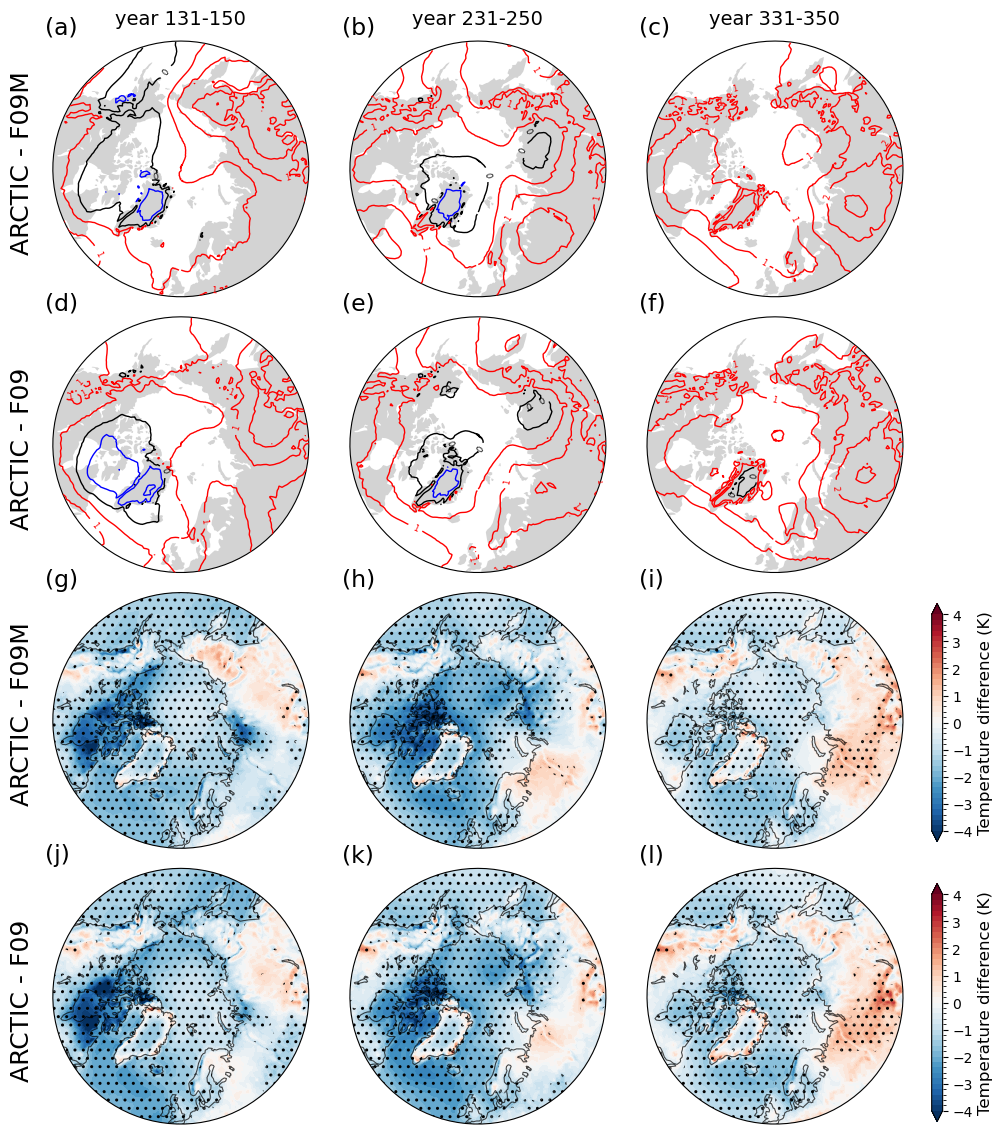

In [31]:
fig = plt.figure(figsize = (11,14))
gs=GridSpec(4,3)
plt.rcParams['axes.titlepad'] = 14

# Modify values here
cmap2 = plt.cm.RdBu_r
bounds2 = np.arange(-4.,4.1,0.2)
bounds2min = [-100]
bounds2max = [100]
norm2 = mpl.colors.BoundaryNorm(bounds2, cmap2.N, extend='both')
ticks2 = np.arange(-4.,4.1,1.)

levels = np.arange(-2.5, 2.6, 0.5)
colors = ('blue', 'blue', 'blue', 'blue', 'blue', 'black', 'red', 'red', 'red', 'red', 'red')
lw = 1.

#=============F09M-ARCTIC===============
ax1 = plt.subplot(gs[0],projection=crs_np)
plot_arctic(ax1,50)
im1 = ax1.contour(f09_lon, f09_lat, -f09_ARCTIC_dThyps_JJA_stab.where(f09_lat>49), levels=levels, colors=colors, linewidths=lw, transform = crs_ll, zorder=5)#, norm=norm3)
plt.clabel(im1, levels[1::2], fontsize=6)
ax1.set_title('year 131-150', fontsize=14)
ax1.add_feature(cfeature.LAND, zorder=2, facecolor='lightgray')
ax1.add_feature(cfeature.COASTLINE, zorder=3, color='none', lw=0.8)
ax1.add_feature(cfeature.LAKES, zorder=4, edgecolor='none', lw=0.8, facecolor='white')
plt.text(-5000000, 5000000, '(a)', fontsize=17)#, weight='bold')
plt.text(-6300000, -2900000, 'ARCTIC - F09M', rotation=90, fontsize=18)

ax2 = plt.subplot(gs[1],projection=crs_np)
plot_arctic(ax2,50)
im2 = ax2.contour(f09_lon, f09_lat, -f09_ARCTIC_dThyps_JJA_mid.where(f09_lat>49), levels=levels, colors=colors, linewidths=lw, transform = crs_ll, zorder=5)#, norm=norm3)
plt.clabel(im2, levels[1::2], fontsize=6)
ax2.set_title('year 231-250', fontsize=14)
ax2.add_feature(cfeature.LAND, zorder=2, facecolor='lightgray')
ax2.add_feature(cfeature.COASTLINE, zorder=3, color='none', lw=0.8)
ax2.add_feature(cfeature.LAKES, zorder=4, edgecolor='none', lw=0.8, facecolor='white')
plt.text(-5000000, 5000000, '(b)', fontsize=17)

ax3 = plt.subplot(gs[2],projection=crs_np)
plot_arctic(ax3,50)
im3 = ax3.contour(f09_lon, f09_lat, -f09_ARCTIC_dThyps_JJA_end.where(f09_lat>49), levels=levels, colors=colors, linewidths=lw, transform = crs_ll, zorder=5)
plt.clabel(im3, levels[1::2], fontsize=6)
ax3.set_title('year 331-350', fontsize=14)
ax3.add_feature(cfeature.LAND, zorder=2, facecolor='lightgray')
ax3.add_feature(cfeature.COASTLINE, zorder=3, color='none', lw=0.8)
ax3.add_feature(cfeature.LAKES, zorder=4, edgecolor='none', lw=0.8, facecolor='white')
plt.text(-5000000, 5000000, '(c)', fontsize=17)

#=============F09-ARCTIC===============

ax4 = plt.subplot(gs[3],projection=crs_np)
plot_arctic(ax4,50)
im4 = ax4.contour(f09_lon, f09_lat, -f09_nohacks_ARCTIC_dThyps_JJA_stab.where(f09_lat>49), levels=levels, colors=colors, linewidths=lw, transform = crs_ll, zorder=5)
plt.clabel(im4, levels[1::2], fontsize=6)
ax4.add_feature(cfeature.LAND, zorder=2, facecolor='lightgray')
ax4.add_feature(cfeature.COASTLINE, zorder=3, color='none', lw=0.8)
ax4.add_feature(cfeature.LAKES, zorder=4, edgecolor='none', lw=0.8, facecolor='white')
plt.text(-5000000, 5000000, '(d)', fontsize=17)
plt.text(-6300000, -2900000, 'ARCTIC - F09', rotation=90, fontsize=18)

ax5 = plt.subplot(gs[4],projection=crs_np)
plot_arctic(ax5,50)
im5 = ax5.contour(f09_lon, f09_lat, -f09_nohacks_ARCTIC_dThyps_JJA_mid.where(f09_lat>49), levels=levels, colors=colors, linewidths=lw, transform = crs_ll, zorder=5)
plt.clabel(im5, levels[1::2], fontsize=6)
ax5.add_feature(cfeature.LAND, zorder=2, facecolor='lightgray')
ax5.add_feature(cfeature.COASTLINE, zorder=3, color='none', lw=0.8)
ax5.add_feature(cfeature.LAKES, zorder=4, edgecolor='none', lw=0.8, facecolor='white')
plt.text(-5000000, 5000000, '(e)', fontsize=17)

ax6 = plt.subplot(gs[5],projection=crs_np)
plot_arctic(ax6,50)
im6 = ax6.contour(f09_lon, f09_lat, -f09_nohacks_ARCTIC_dThyps_JJA_end.where(f09_lat>49), levels=levels, colors=colors, linewidths=lw, transform = crs_ll, zorder=5)
plt.clabel(im6, levels[1::2], fontsize=6)
ax6.add_feature(cfeature.LAND, zorder=2, facecolor='lightgray')
ax6.add_feature(cfeature.COASTLINE, zorder=3, color='none', lw=0.8)
ax6.add_feature(cfeature.LAKES, zorder=4, edgecolor='none', lw=0.8, facecolor='white')
plt.text(-5000000, 5000000, '(f)', fontsize=17)

#=============F09M-ARCTIC===============
ax7 = plt.subplot(gs[6],projection=crs_np)
plot_arctic(ax7,50)
im7 = ax7.contourf(f09_lon2, f09_lat, -f09_ARCTIC_dTREFHT_JJA_stab2, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll)
ax7.contourf(f09_lon, f09_lat, f09_ARCTIC_TREFHT_JJA_sig_stab, transform=crs_ll, hatches=['..'], alpha=0)
ax7.add_feature(cfeature.LAND, facecolor='none')
ax7.add_feature(cfeature.COASTLINE, color='black', lw=0.8, alpha=0.7)
ax7.add_feature(cfeature.LAKES, edgecolor='black', lw=0.8, alpha=0.7, facecolor='none')
plt.text(-5000000, 5000000, '(g)', fontsize=17)
plt.text(-6300000, -2900000, 'ARCTIC - F09M', rotation=90, fontsize=18)

ax8 = plt.subplot(gs[7],projection=crs_np)
plot_arctic(ax8,50)
im8 = ax8.contourf(f09_lon2, f09_lat, -f09_ARCTIC_dTREFHT_JJA_mid2, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll)
ax8.contourf(f09_lon, f09_lat, f09_ARCTIC_TREFHT_JJA_sig_mid, transform=crs_ll, hatches=['..'], alpha=0)
ax8.add_feature(cfeature.LAND, facecolor='none')
ax8.add_feature(cfeature.COASTLINE, color='black', lw=0.8, alpha=0.7)
ax8.add_feature(cfeature.LAKES, edgecolor='black', lw=0.8, alpha=0.7, facecolor='none')
plt.text(-5000000, 5000000, '(h)', fontsize=17)

ax9 = plt.subplot(gs[8],projection=crs_np)
plot_arctic(ax9,50)
im9 = ax9.contourf(f09_lon2, f09_lat, -f09_ARCTIC_dTREFHT_JJA_end2, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll)
ax9.contourf(f09_lon, f09_lat, f09_ARCTIC_TREFHT_JJA_sig_end, transform=crs_ll, hatches=['..'], alpha=0)
ax9.add_feature(cfeature.LAND, facecolor='none')
ax9.add_feature(cfeature.COASTLINE, color='black', lw=0.8, alpha=0.7)
ax9.add_feature(cfeature.LAKES, edgecolor='black', lw=0.8, alpha=0.7, facecolor='none')
plt.text(-5000000, 5000000, '(i)', fontsize=17)

# colorbar
cbar_ax9 = fig.add_axes([0.925, 0.31, 0.01, 0.17])
cb9 = fig.colorbar(im9, cax=cbar_ax9, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb9.set_label(label='Temperature difference (K)', size=12)
cb9.ax.tick_params(labelsize=10)

#=============F09-ARCTIC===============

ax10 = plt.subplot(gs[9],projection=crs_np)
plot_arctic(ax10,50)
im10 = ax10.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_dTREFHT_JJA_stab2, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll)
ax10.contourf(f09_lon, f09_lat, f09_nohacks_ARCTIC_TREFHT_JJA_sig_stab, transform=crs_ll, hatches=['..'], alpha=0)
ax10.add_feature(cfeature.LAND, facecolor='none')
ax10.add_feature(cfeature.COASTLINE, color='black', lw=0.8, alpha=0.7)
ax10.add_feature(cfeature.LAKES, edgecolor='black', lw=0.8, alpha=0.7, facecolor='none')
plt.text(-5000000, 5000000, '(j)', fontsize=17)
plt.text(-6300000, -2900000, 'ARCTIC - F09', rotation=90, fontsize=18)

ax11 = plt.subplot(gs[10],projection=crs_np)
plot_arctic(ax11,50)
im11 = ax11.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_dTREFHT_JJA_mid2, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll)
ax11.contourf(f09_lon, f09_lat, f09_nohacks_ARCTIC_TREFHT_JJA_sig_mid, transform=crs_ll, hatches=['..'], alpha=0)
ax11.add_feature(cfeature.LAND, facecolor='none')
ax11.add_feature(cfeature.COASTLINE, color='black', lw=0.8, alpha=0.7)
ax11.add_feature(cfeature.LAKES, edgecolor='black', lw=0.8, alpha=0.7, facecolor='none')
plt.text(-5000000, 5000000, '(k)', fontsize=17)

ax12 = plt.subplot(gs[11],projection=crs_np)
plot_arctic(ax12,50)
im12 = ax12.contourf(f09_lon2, f09_lat, -f09_nohacks_ARCTIC_dTREFHT_JJA_end2, cmap=cmap2, levels=bounds2, norm=norm2, extend='both', transform=crs_ll)
ax12.contourf(f09_lon, f09_lat, f09_nohacks_ARCTIC_TREFHT_JJA_sig_end, transform=crs_ll, hatches=['..'], alpha=0)
ax12.add_feature(cfeature.LAND, facecolor='none')
ax12.add_feature(cfeature.COASTLINE, color='black', lw=0.8, alpha=0.7)
ax12.add_feature(cfeature.LAKES, edgecolor='black', lw=0.8, alpha=0.7, facecolor='none')
plt.text(-5000000, 5000000, '(l)', fontsize=17)

# colorbar
cbar_ax12 = fig.add_axes([0.925, 0.11, 0.01, 0.17])
cb12 = fig.colorbar(im12, cax=cbar_ax12, orientation='vertical', boundaries=bounds2min+bounds2+bounds2max, ticks=ticks2)
cb12.set_label(label='Temperature difference (K)', size=12)
cb12.ax.tick_params(labelsize=10)


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.15,
                    hspace=0.1)

plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Contour_Thyps_Map_T2m_diff_JJA_NH_sig.png', dpi=300, bbox_inches='tight', facecolor='w', transparent = False)